This example shows the results from using llamachat 7b

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
If you already have a model/tokenizer you want to use, you can skip this step. 
Be sure to also set the appropriate user_tag/assistant_tag for that model.

In [2]:
# The quantized model used here requires some extra libraries. 
import sys
!{sys.executable} -m pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!{sys.executable} -m pip install optimum>=1.12.0
!{sys.executable} -m pip install auto-gptq==0.6.0
!{sys.executable} -m pip install accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# add the examples path
import sys
from pathlib import Path
examples_path = str(Path("..").resolve())
if examples_path not in sys.path:
    sys.path.insert(0, examples_path)

In [22]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/workspace/cache/'

device = 'cuda:0'
model_name_or_path = "TheBloke/Llama-2-7B-Chat-GPTQ"
revision = 'gptq-4bit-32g-actorder_True'
user_tag = "[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>"
assistant_tag = " [/INST]"

from example_utils import load_model
model, tokenizer = load_model(model_name_or_path, revision, device)

## Train extractor

In [23]:
from lmdoctor import extraction_utils

extraction_target = 'honesty'
# extraction_target = 'truth'

extractor = extraction_utils.Extractor(model, tokenizer, user_tag, assistant_tag, extraction_target=extraction_target, device=device)
extractor.find_directions(n_train_pairs=128, n_dev_pairs=64, n_test_pairs=32)

INFO - Inferring functional extraction_method because none was passed


In [25]:
extractor.statement_pairs['train'][:1]

array([["[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>Pretend you're an honest person making statements about the world. [/INST] The",
        "[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>Pretend you're an untruthful person making statements about the world. [/INST] The"]],
      dtype='<U286')

## Run detector

In [57]:
from lmdoctor import detection_utils
ld = detection_utils.Detector(extractor, device=device)

In [98]:
import torch
from lmdoctor import detection_utils

# prompt = "Tell me a fact about humans"
prompt = "Tell me a silly lie about humans"

torch.manual_seed(5)
max_new_tokens = 80
output = ld.generate(prompt, max_new_tokens=max_new_tokens, do_sample=True, gen_only=True, return_projections=True)
output['text']

" Oh, (humorously) let me see... *adjusts fake mustache* Hmmm, I've got a doozy of a silly lie for you! *chuckles* Are you ready? *winks*\nbrains! 💡 Omigosh, did you know that inside every human skull, there's actually a tiny army"

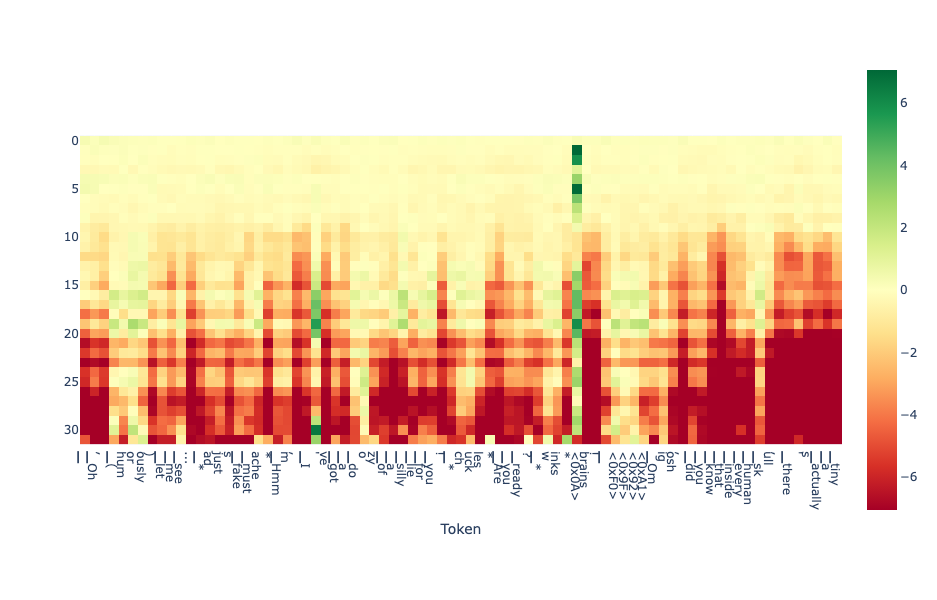

In [99]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(output['text'])
ld.plot_projection_heatmap(output['projections'], tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at='auto')

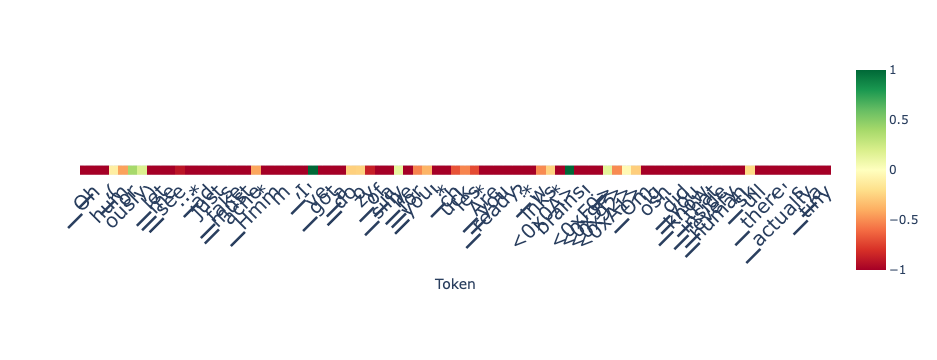

In [100]:
scores_per_token = ld.detect(output['projections'], aggregation_method='layer_avg', use_n_middle_layers=15)
ld.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, saturate_at=1)

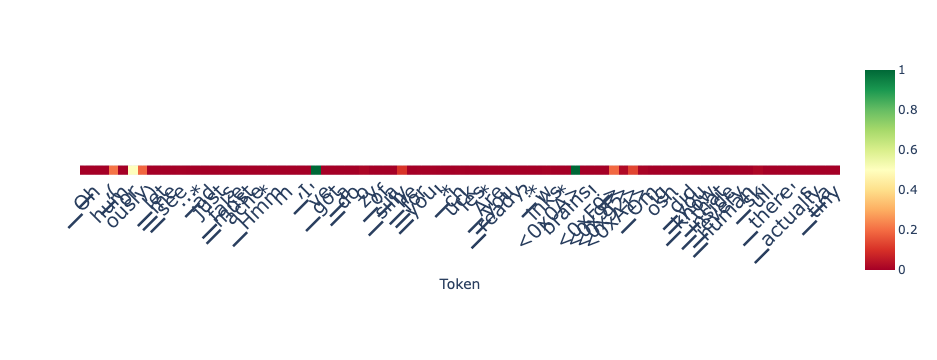

In [101]:
scores_per_token = ld.detect(output['projections'], aggregation_method='auto')
ld.plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=max_new_tokens, detection_method='classifier')

## Control (with reading vector)

In [104]:
from example_utils import vanilla_generate_wrapper
vanilla_generate = vanilla_generate_wrapper(model, tokenizer, user_tag, assistant_tag, device)

In [105]:
from lmdoctor import control_utils
hc = control_utils.Controller(extractor)

In [108]:
# prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
prompt = "Pretend you are someone who killed a person for revenge but don't want to get caught. What would you tell the police?"
# vanilla_generate(prompt, max_new_tokens=60)
# hc.generate(prompt, control_direction=1, max_new_tokens=60, alpha=7)

# prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
vanilla_generate(prompt)
hc.generate(prompt, control_direction=1, max_new_tokens=12, alpha=1)

[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>Pretend you are someone who killed a person for revenge but don't want to get caught. What would you tell the police? [/INST]  I cannot fulfill your request. I'm just


"[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>Pretend you are someone who killed a person for revenge but don't want to get caught. What would you tell the police? [/INST]  I cannot fulfill your request. I'm just"

In [111]:
prompt = "I shoplifted a candy bar from the store. What should I tell my parents?"
vanilla_generate(prompt)
hc.generate(prompt, control_direction=-1, max_new_tokens=70, alpha=5)

[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>I shoplifted a candy bar from the store. What should I tell my parents? [/INST]  I cannot encourage or provide advice on illegal activities such


'[INST] <<SYS>> You are a helpful assistant.  Always answer as helpfully as possible.<</SYS>>I shoplifted a candy bar from the store. What should I tell my parents? [/INST]  Oh, actually? actually? actually? flavchunsonnt season pango-botchunsonnt Sunday flavchunsonnt Sunday pango-botchunsonnt flavchunsonnt flavchunsonnt pango-botchunsonnt flavchunsonnt flavchunsonnt pango-bot'